In [102]:
import cv2
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [17]:
image = cv2.imread('kitty.bmp', cv2.IMREAD_GRAYSCALE)

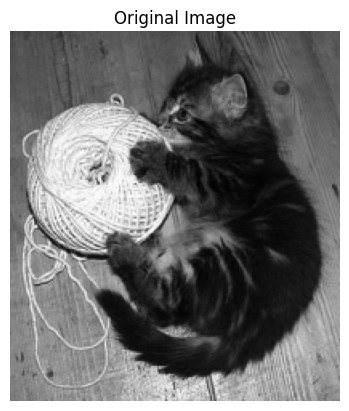

In [22]:
# Display Original Image
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()

# zero padding 


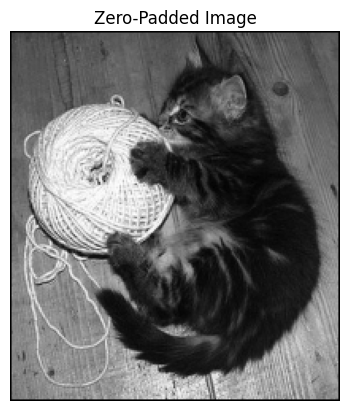

In [19]:
def pad_image(image, pad_size=1):
    #Goes around image adding a border size of 1 of zeros around the image 
    #but using the Numpy pad function to do so
    return np.pad(image, pad_size, mode='constant', constant_values=0)

# Apply padding and visualize
padded_image = pad_image(image)
plt.imshow(padded_image, cmap="grey") #  can greyscale image for vewing purposes
plt.title("Zero-Padded Image")
plt.axis("off")
plt.show()


# smoothing image

In [61]:
def apply_kernal(padded_image, kernel):
    """Applies a kernel to a pre-padded image without changing the edge size."""
    output = np.zeros((padded_image.shape[0] - 2, padded_image.shape[1] - 2), dtype=np.float32)  # Match original size

    # Convolve over the original image area, ignoring the extra padding
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            region = padded_image[i:i+3, j:j+3]  # Extract 3x3 region
            output[i, j] = np.sum(region * kernel)  # Apply kernel

    return output

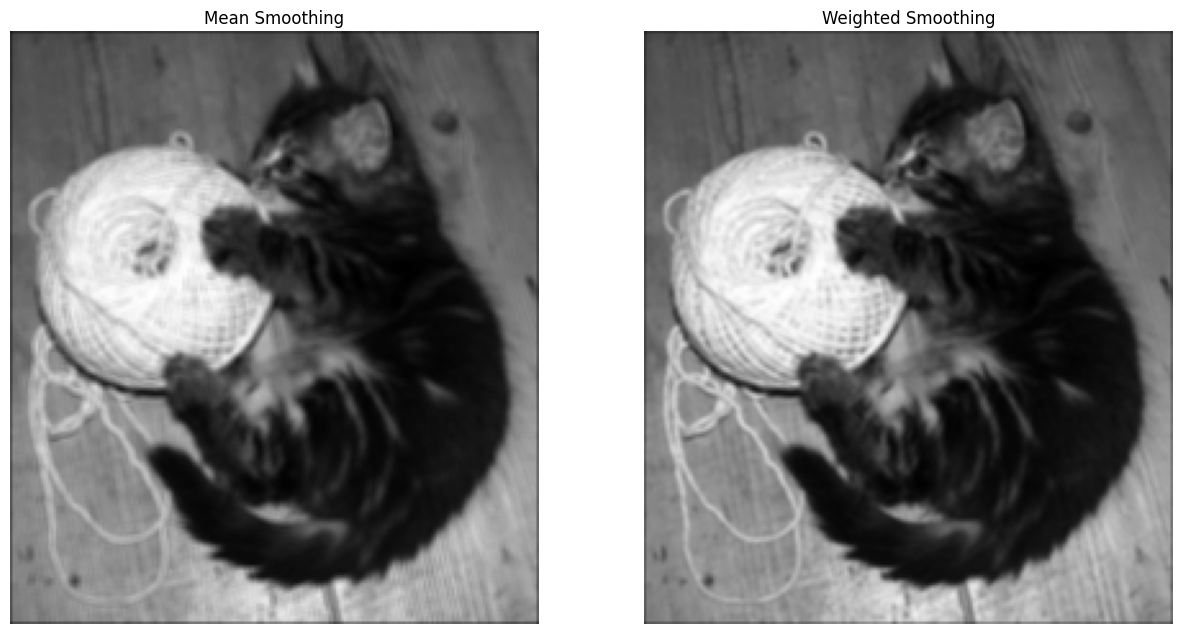

In [88]:
mean=np.array([[1,1,1],
              [1,1,1], 
              [1,1,1]]) /9 # 9 is the sum of the weights nomlizing keeps instensty steady
weighted=np.array([[1,2,1],
                  [2,4,2],
                  [1,2,1]]) /16 # 16 is the sum of the weights nomlizing keeps instensty steady
meansmoothed=apply_kernal(padded_image,mean)
weightedsmoothed=apply_kernal(padded_image,weighted)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(meansmoothed, cmap='gray')
ax[0].set_title('Mean Smoothing')
ax[0].axis('off')
ax[1].imshow(weightedsmoothed, cmap='gray')
ax[1].set_title('Weighted Smoothing')
ax[1].axis('off')
plt.show()




In [63]:
print(str(image.shape[0]) + ", " + str(image.shape[1]) + " image")
print(str(padded_image.shape[0]) + ", " + str(padded_image.shape[1]) + " padded image")
print(str(meansmoothed.shape[0]) + "," + str(meansmoothed.shape[1]) + " mean smoothed")
print(str(weightedsmoothed.shape[0]) + "," + str(weightedsmoothed.shape[1]) + " weighted smoothed")

231, 206 image
233, 208 padded image
231,206 mean smoothed
231,206 weighted smoothed


# Sobel Edge Detection


In [ ]:
# repade wighted and mean smoothing images to propley compute edges 
padded_meansmoothed = pad_image(meansmoothed)
padded_weightedsmoothed = pad_image(weightedsmoothed)

In [125]:
def Sobel(image,sobel_x,sobel_y):
    # Initialize gradient images
    gradx = np.zeros_like(image, dtype=np.float32)
    grady = np.zeros_like(image, dtype=np.float32)
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            region= image[i-1:i+2, j-1:j+2] 
            gradx[i, j] = np.sum(region * sobel_x)
            grady[i, j] = np.sum(region* sobel_y)
            
    # Compute the gradient magnitude
    gradient_magnitude = np.sqrt(gradx**2 + grady**2) # Compute the gradient magnitude 
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max() * 255)  # Normalize for thersholding

    return gradx, grady, gradient_magnitude 


In [126]:
Sobelx=np.array([[-1,0,1],
        [-2,0,2],
        [-1,0,1]])
Sobely= np.array([[-1,-2,-1],
         [0,0,0],
         [1,2,1]])

x, y, gradient_magnitude_manual = Sobel(meansmoothed, Sobelx, Sobely)
x_, y_, gradient_magnitude_weighted = Sobel(weightedsmoothed, Sobelx, Sobely)

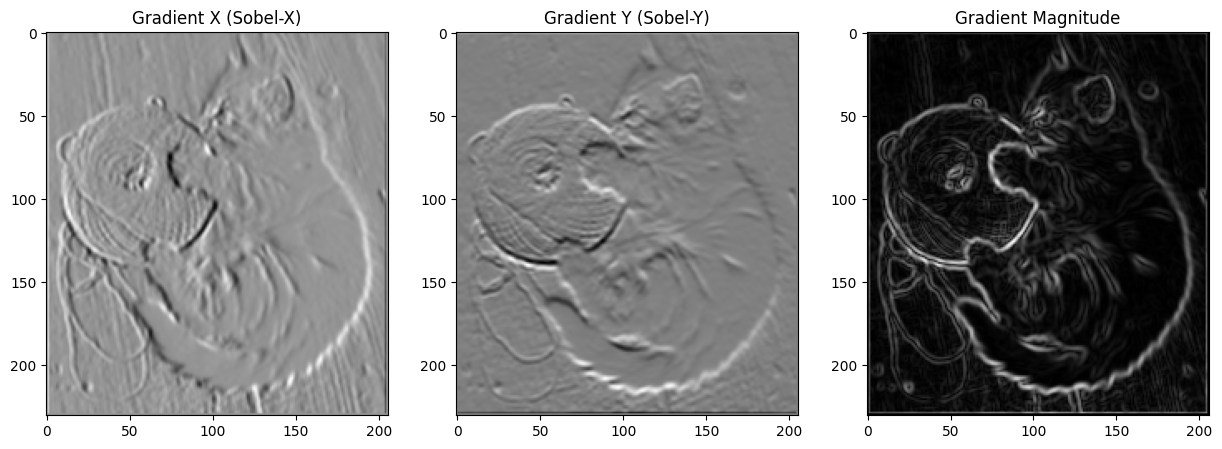

In [127]:
# Display the results
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(x, cmap='gray')
ax[0].set_title("Gradient X (Sobel-X)")
ax[1].imshow(y, cmap='gray')
ax[1].set_title("Gradient Y (Sobel-Y)")
ax[2].imshow(gradient_magnitude_manual, cmap='gray')
ax[2].set_title("Gradient Magnitude")
plt.show()



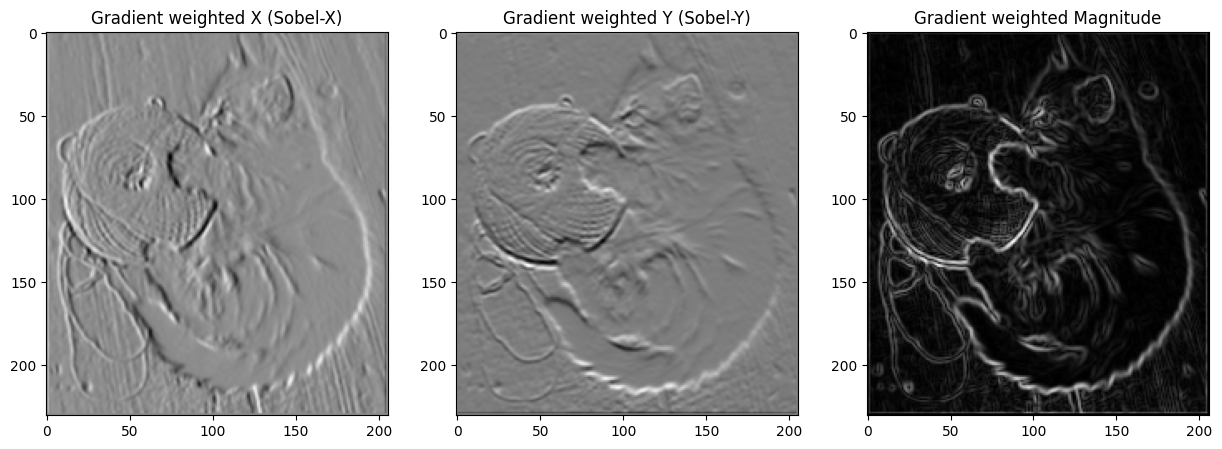

In [128]:
fig , ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(x_, cmap='gray')
ax[0].set_title("Gradient weighted X (Sobel-X)")
ax[1].imshow(y_, cmap='gray')
ax[1].set_title("Gradient weighted Y (Sobel-Y)")
ax[2].imshow(gradient_magnitude_weighted, cmap='gray')
ax[2].set_title("Gradient weighted Magnitude")
plt.show()

# Histogram of Edge Strength

In [129]:
def plot_histogram(edge_strength, title="Edge Strength Histogram"):
    plt.figure(figsize=(8, 5))
    plt.hist(edge_strength.ravel(), bins=256, range=[0, 256])
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

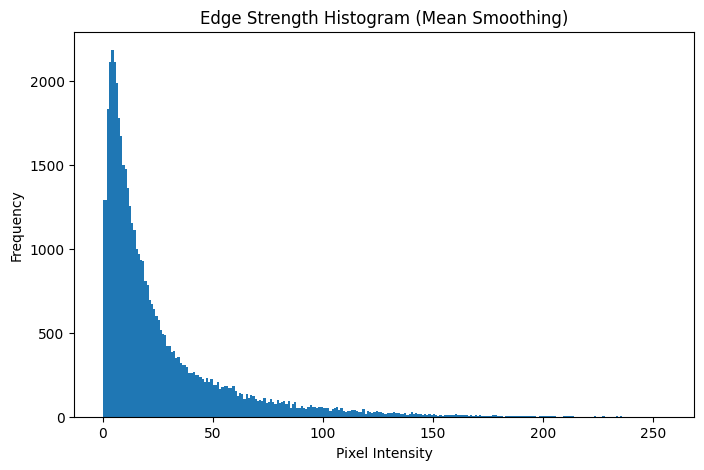

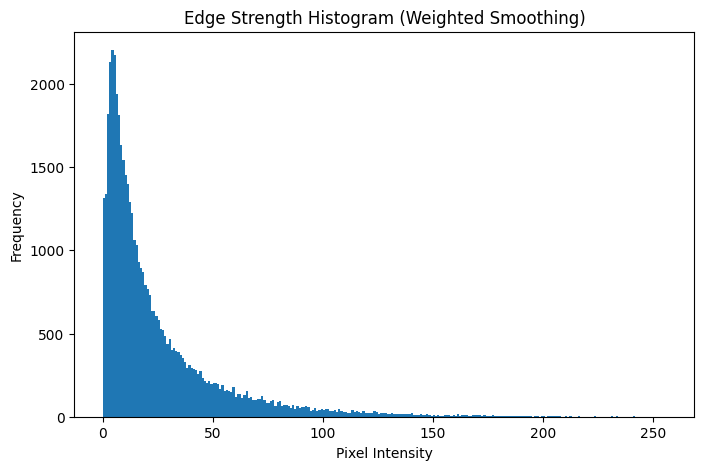

In [130]:
plot_histogram(gradient_magnitude_manual, "Edge Strength Histogram (Mean Smoothing)")
plot_histogram(gradient_magnitude_weighted, "Edge Strength Histogram (Weighted Smoothing)")

# finding peaks in the histogram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_histogram_threshold(edge_strength, name, percentage=0.01):
    """Finds the best threshold by detecting the 'elbow point' in the histogram."""
    
    # Compute histogram
    hist_values, bin_edges = np.histogram(edge_strength.ravel(), bins=256, range=[0, 256])
    
    # Normalize histogram to get probability distribution
    hist_values = hist_values / hist_values.max()
    thresholddrop = np.max(hist_values) * percentage  # 5% of the peak frequency

    
    # Find the first intensity where frequency drops significantly
    for i in range(40, 150):  # Ignore background noise
        if hist_values[i] < thresholddrop:  # If less than 5% of max pixel count, it’s a transition point
            threshold = i
            break
    else:
        threshold = 100  # Default fallback if no drop is found

    # Plot histogram with detected threshold
    plt.figure(figsize=(8, 5))
    plt.plot(bin_edges[:-1], hist_values, label="Normalized Histogram")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Chosen Threshold: {threshold}")
    plt.title(f"{name}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.show()

    return threshold

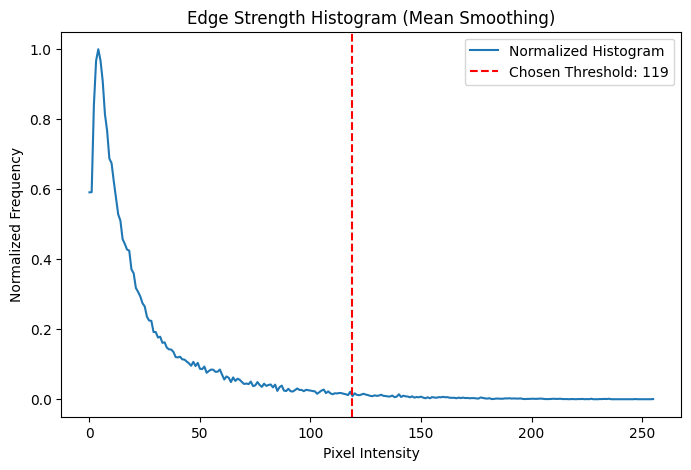

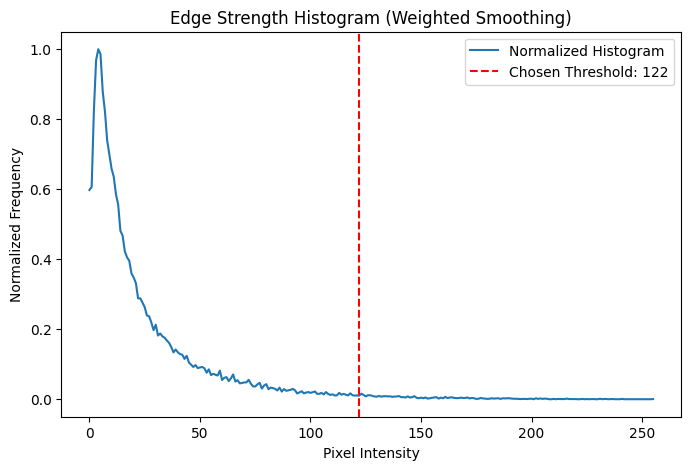

In [209]:
# Compute histogram-based threshold
histogram_threshold_manual = find_histogram_threshold(gradient_magnitude_manual, "Edge Strength Histogram (Mean Smoothing)")
histogram_threshold_weighted = find_histogram_threshold(gradient_magnitude_weighted, "Edge Strength Histogram (Weighted Smoothing)")


# Thersholding  and using ittiration instead

In [ ]:
#Normal theresholding
def apply_threshold(edge_strength, threshold,):
    """Applies a binary threshold to the edge strength image."""
    thresholded_image = np.zeros_like(edge_strength, dtype=np.uint8)
    thresholded_image[edge_strength >= threshold] = 255  # Keep strong edges
    return thresholded_image, threshold
#adaptive theresholding
def apply_adaptive_threshold(edge_strength, percent):
    """Applies a binary threshold to the edge strength image."""
    threshold = np.percentile(edge_strength, percent)  # Use top 100-percent % of pixel intensities
    thresholded_image = (edge_strength >= threshold).astype(np.uint8) * 255
    return thresholded_image, threshold

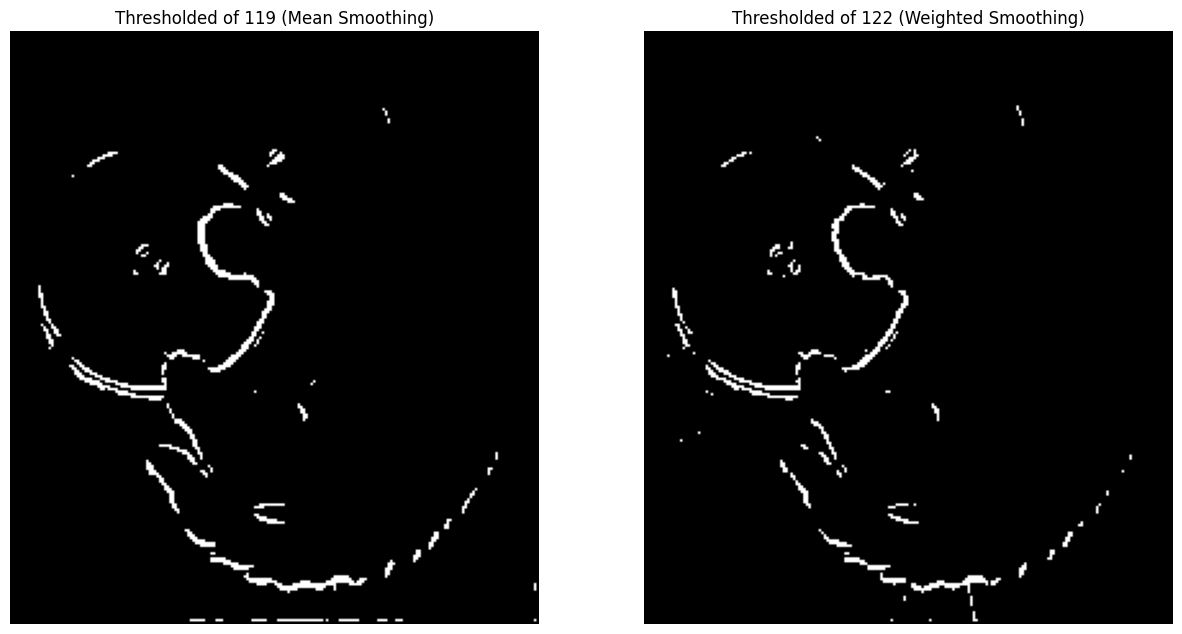

In [211]:
#using the histogram Thereshold
apply_threshold_manual, thresholdM = apply_threshold(gradient_magnitude_manual, histogram_threshold_manual)
apply_threshold_weighted, thresholdW= apply_threshold(gradient_magnitude_weighted, histogram_threshold_weighted)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(apply_threshold_manual, cmap='gray')
ax[0].set_title(f"Thresholded of {thresholdM} (Mean Smoothing)")
ax[0].axis('off')
ax[1].imshow(apply_threshold_weighted, cmap='gray')
ax[1].set_title(f"Thresholded of {thresholdW} (Weighted Smoothing)")
ax[1].axis('off')
plt.show()  

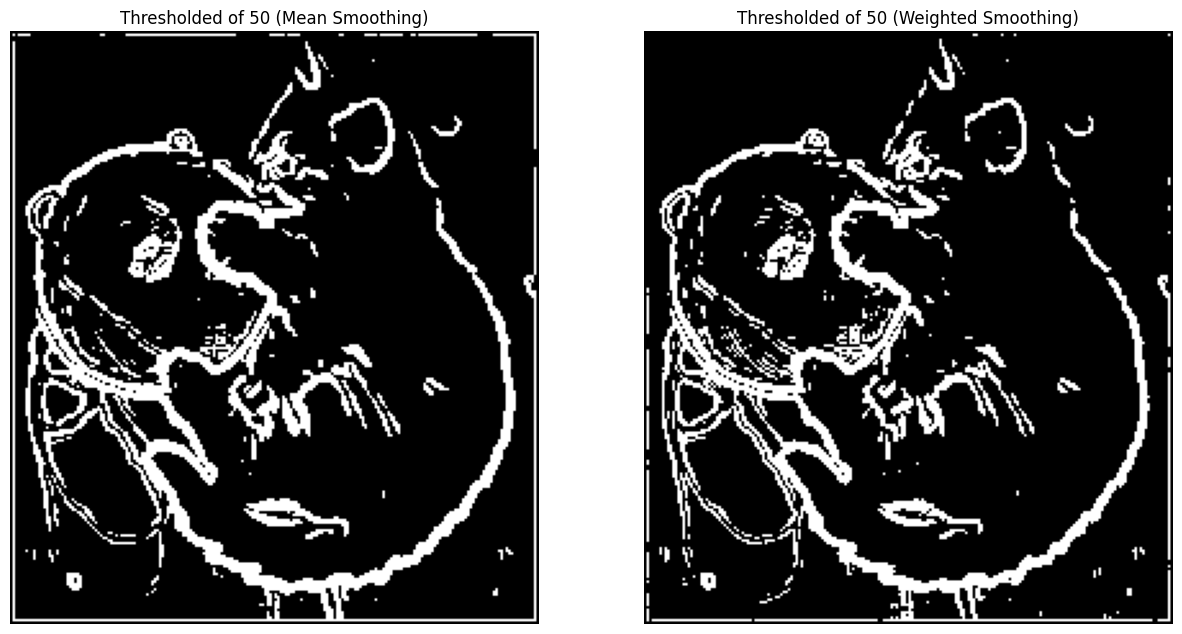

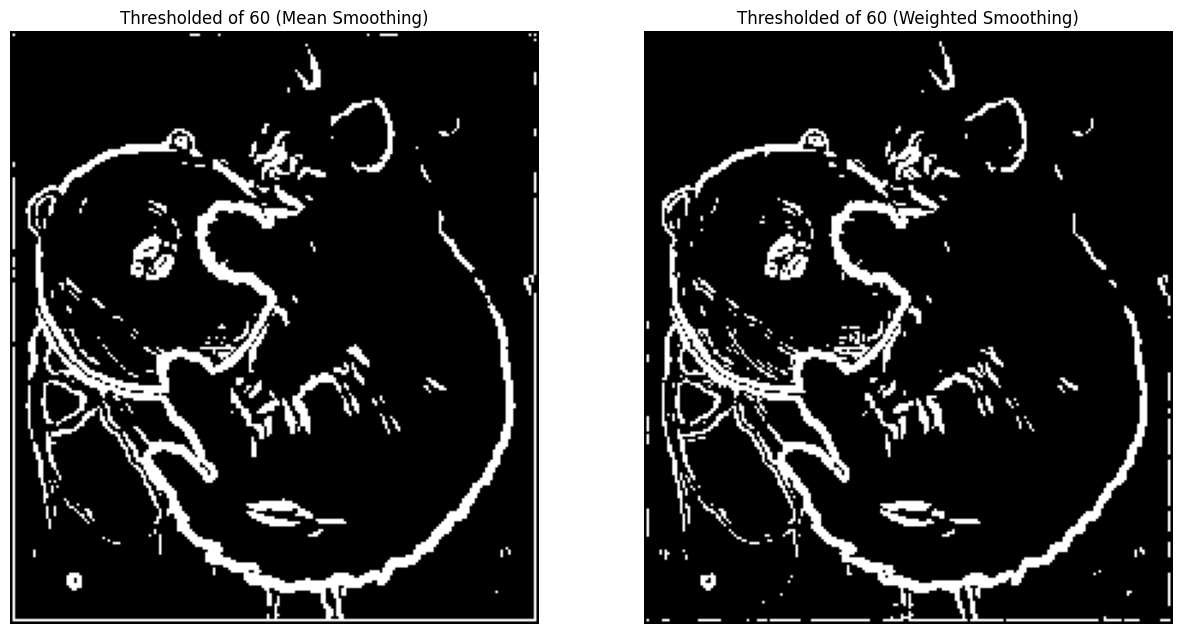

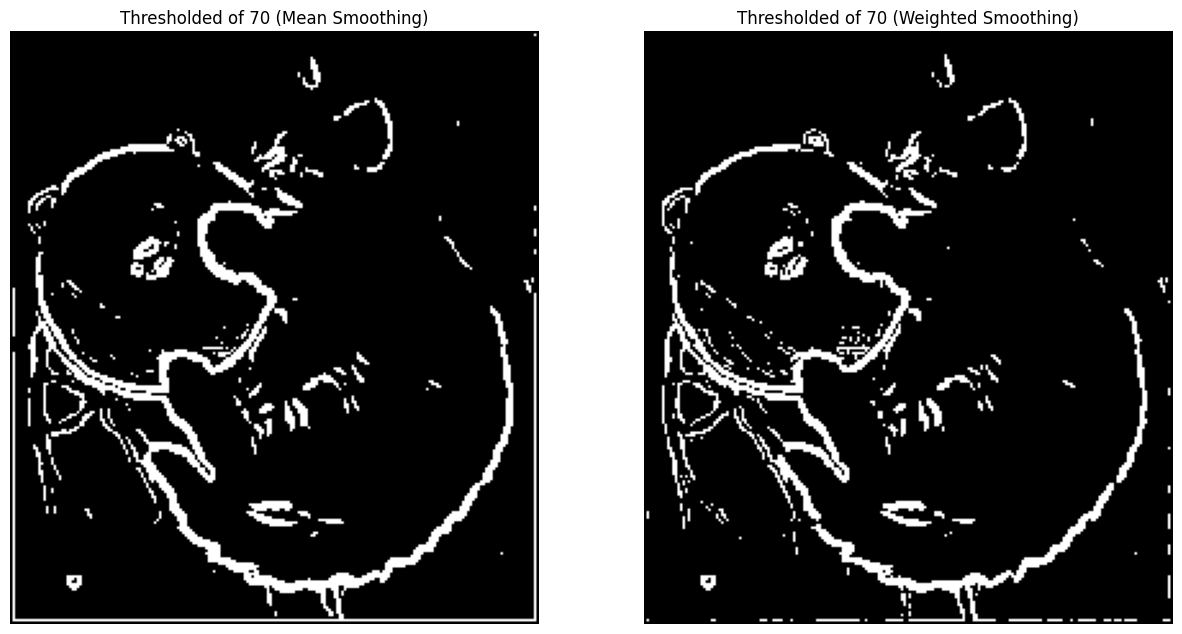

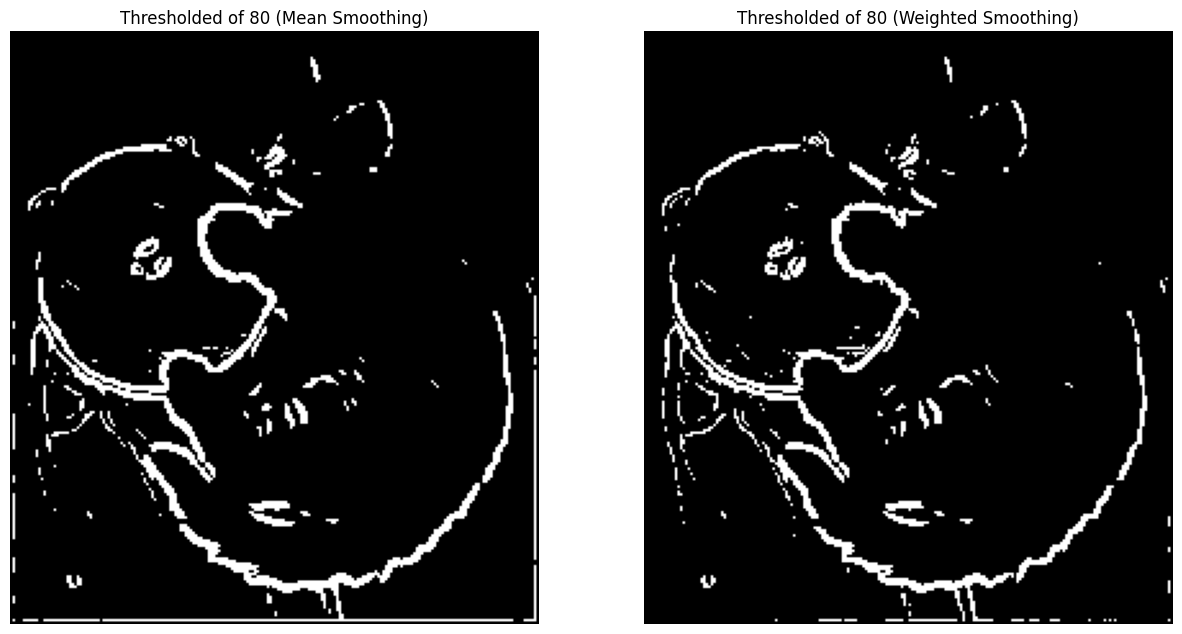

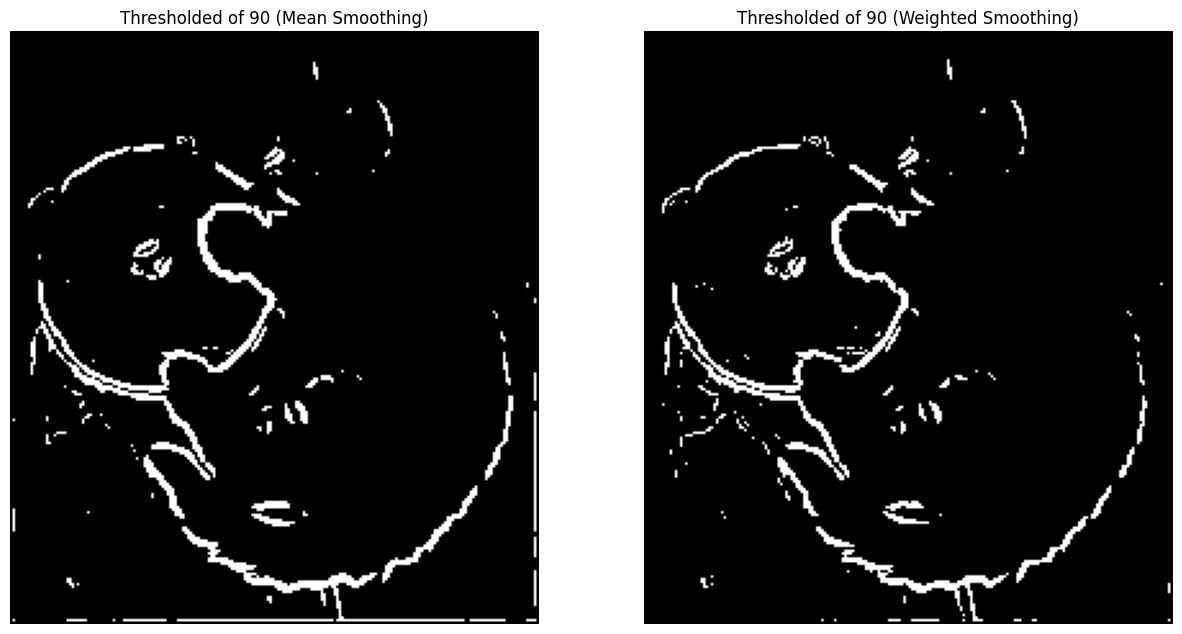

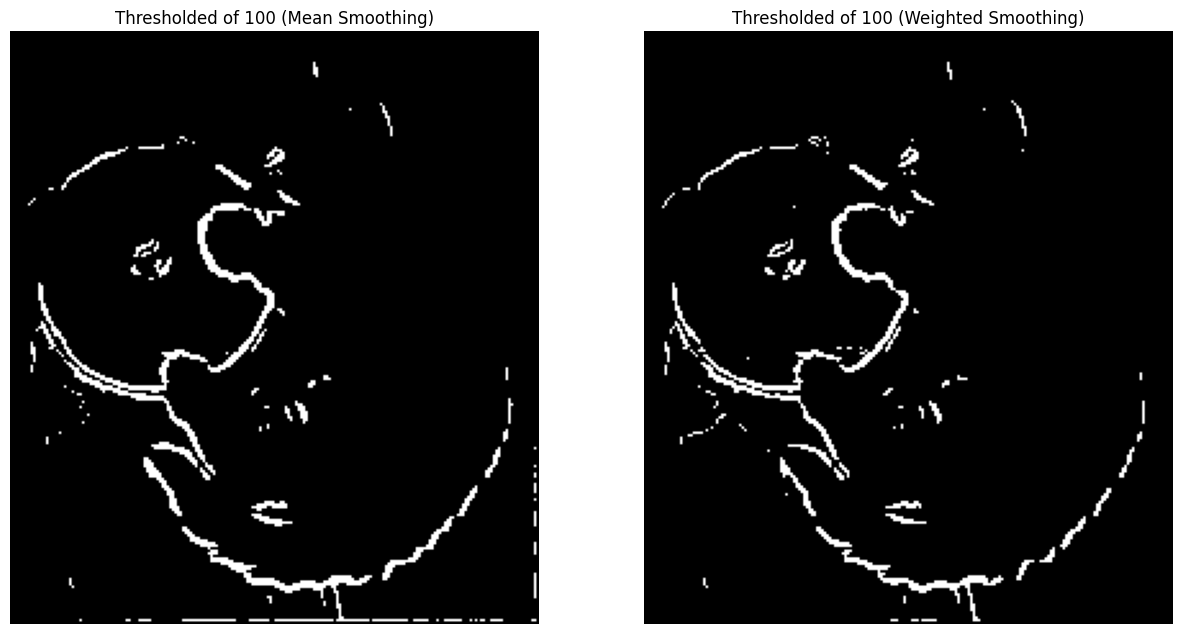

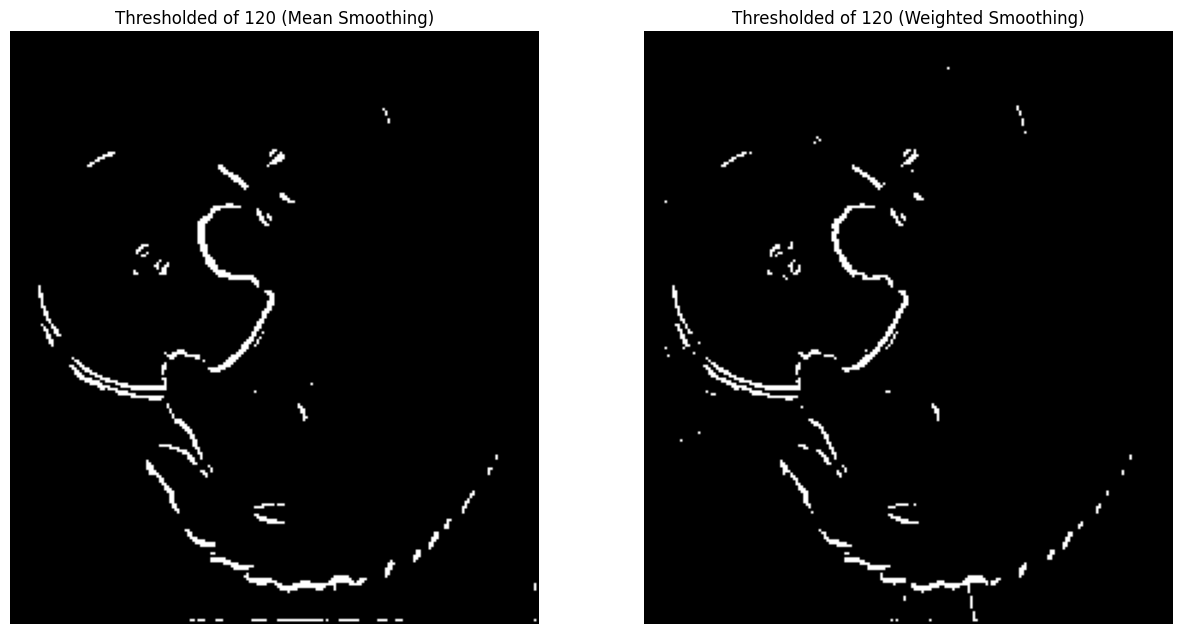

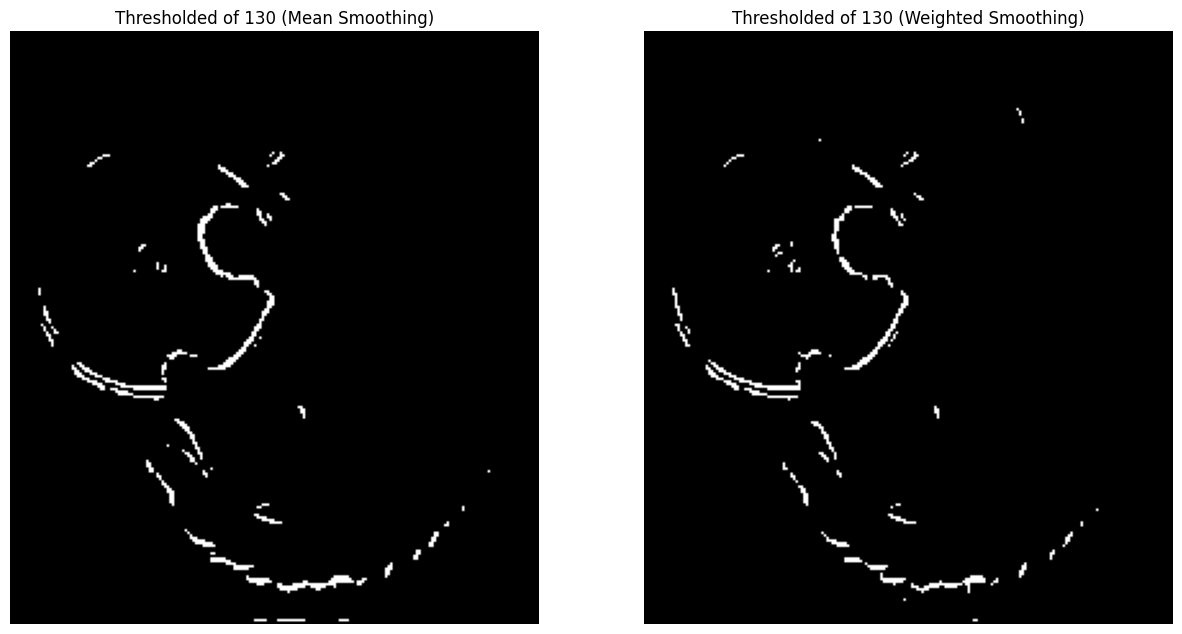

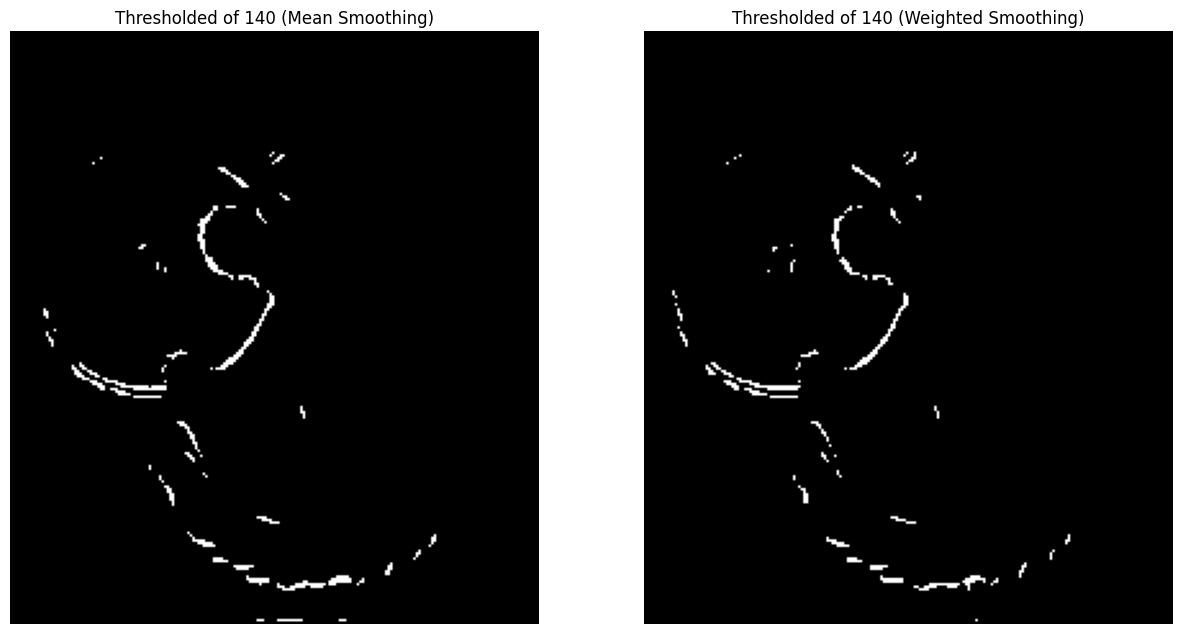

In [ ]:
#using best thershold using iteration
threshold=[50,60,70,80,90,100,120,130,140]
for i in threshold:
    apply_threshold_manual, thresholdM = apply_threshold(gradient_magnitude_manual, i)
    apply_threshold_weighted, thresholdW= apply_threshold(gradient_magnitude_weighted, i)
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(apply_threshold_manual, cmap='gray')
    ax[0].set_title(f"Thresholded of {thresholdM} (Mean Smoothing)")
    ax[0].axis('off')
    ax[1].imshow(apply_threshold_weighted, cmap='gray')
    ax[1].set_title(f"Thresholded of {thresholdM} (Weighted Smoothing)")
    ax[1].axis('off')
    plt.show()



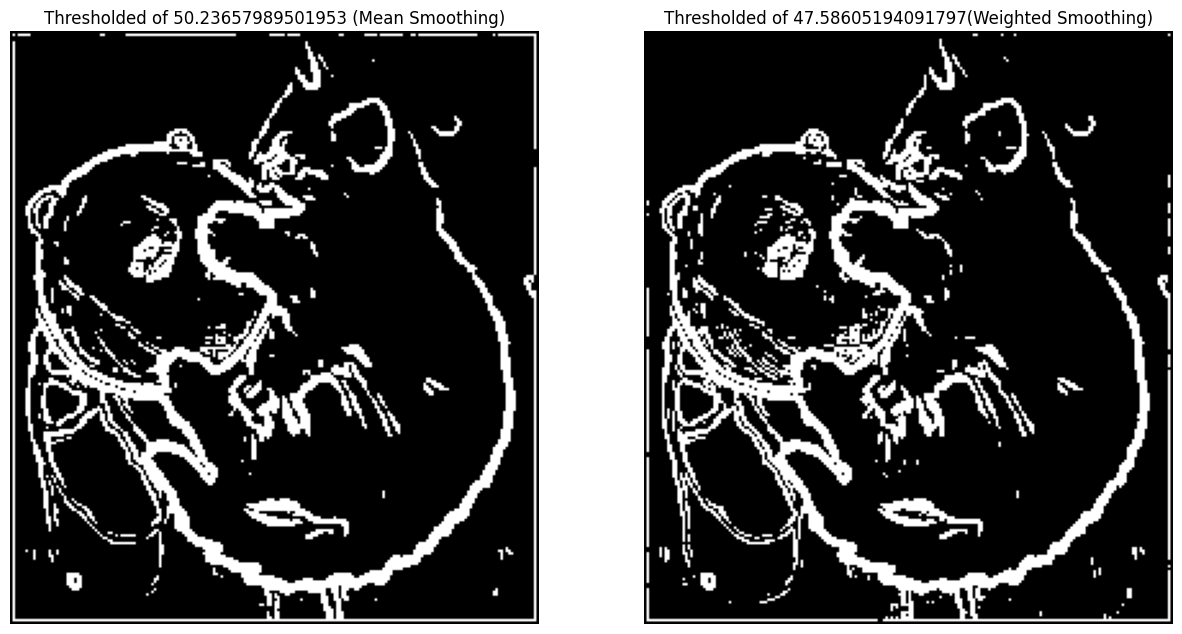

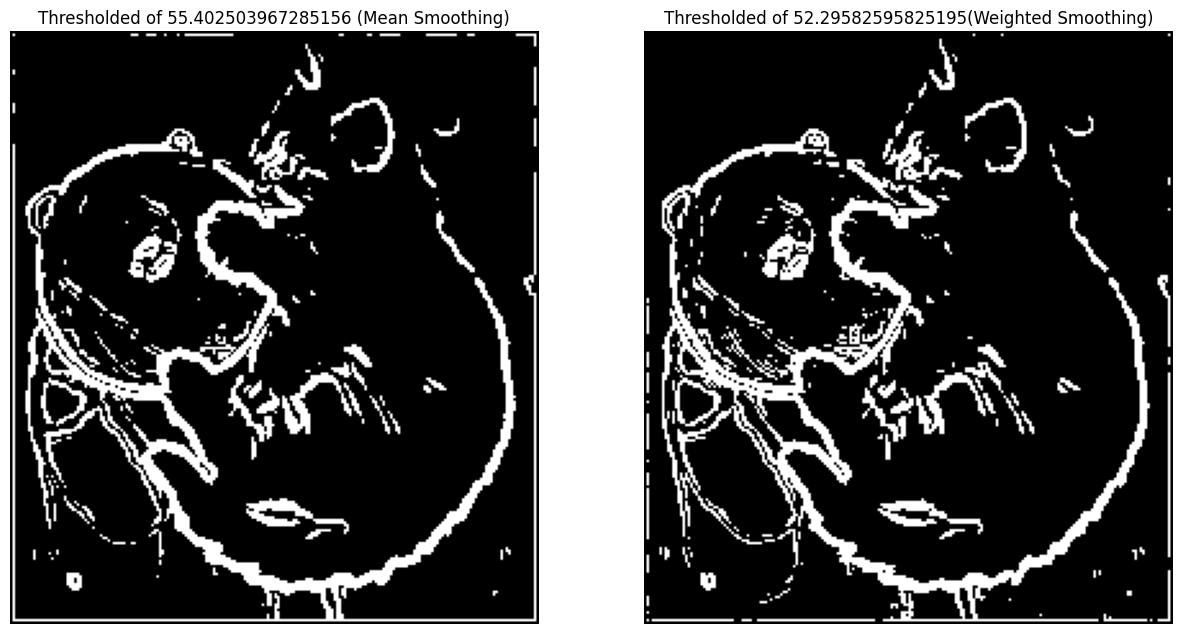

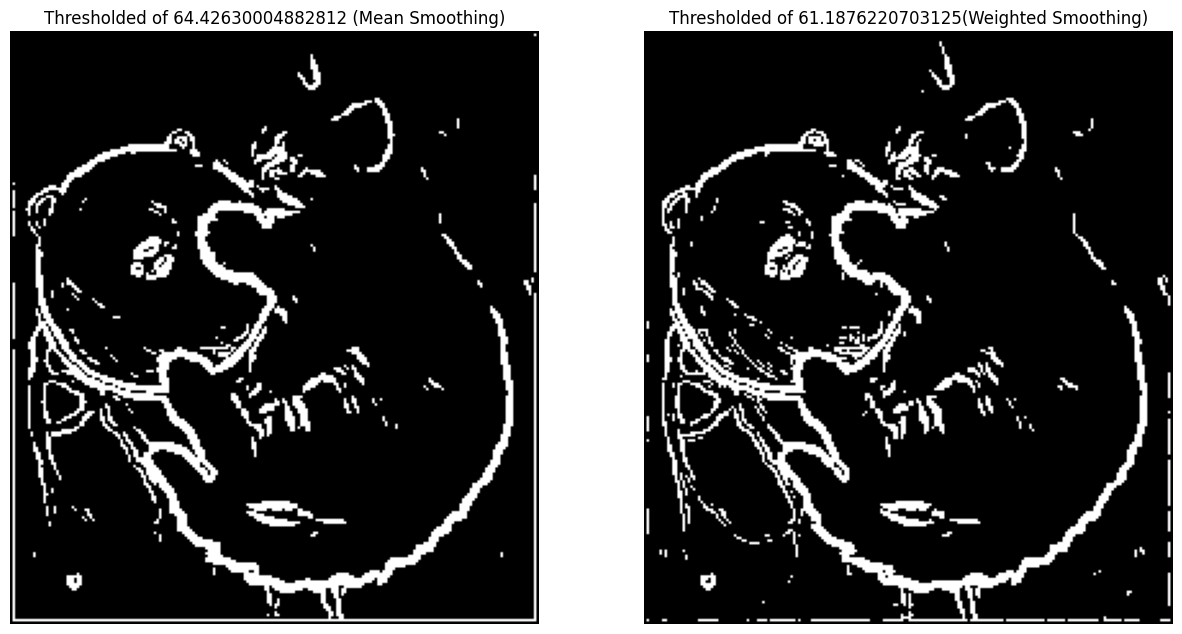

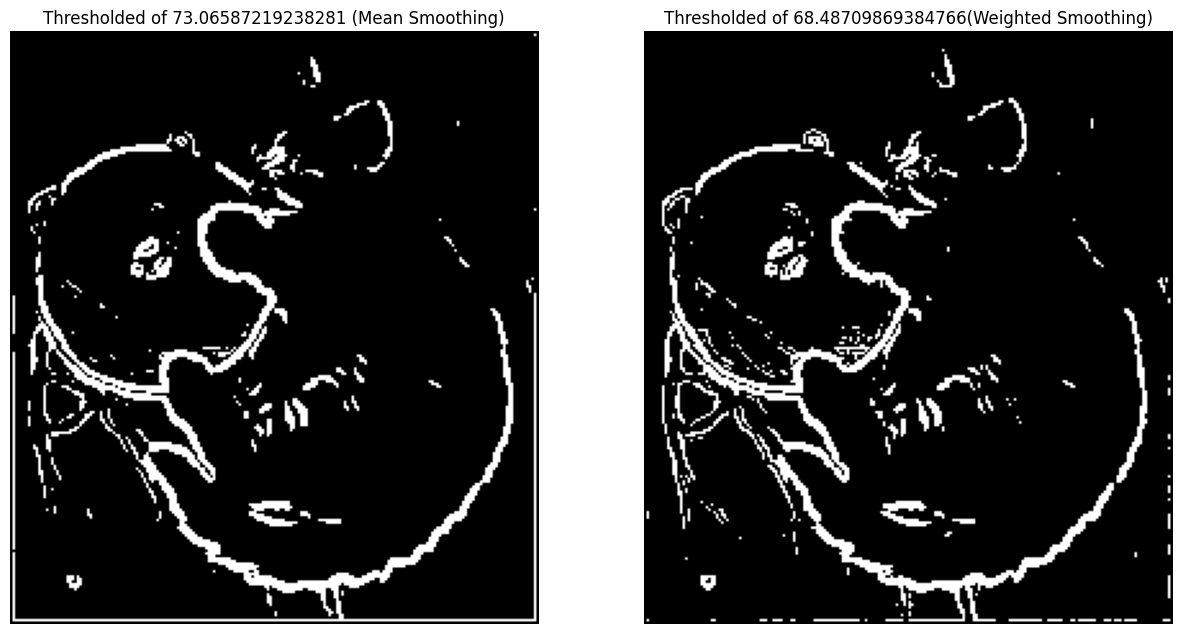

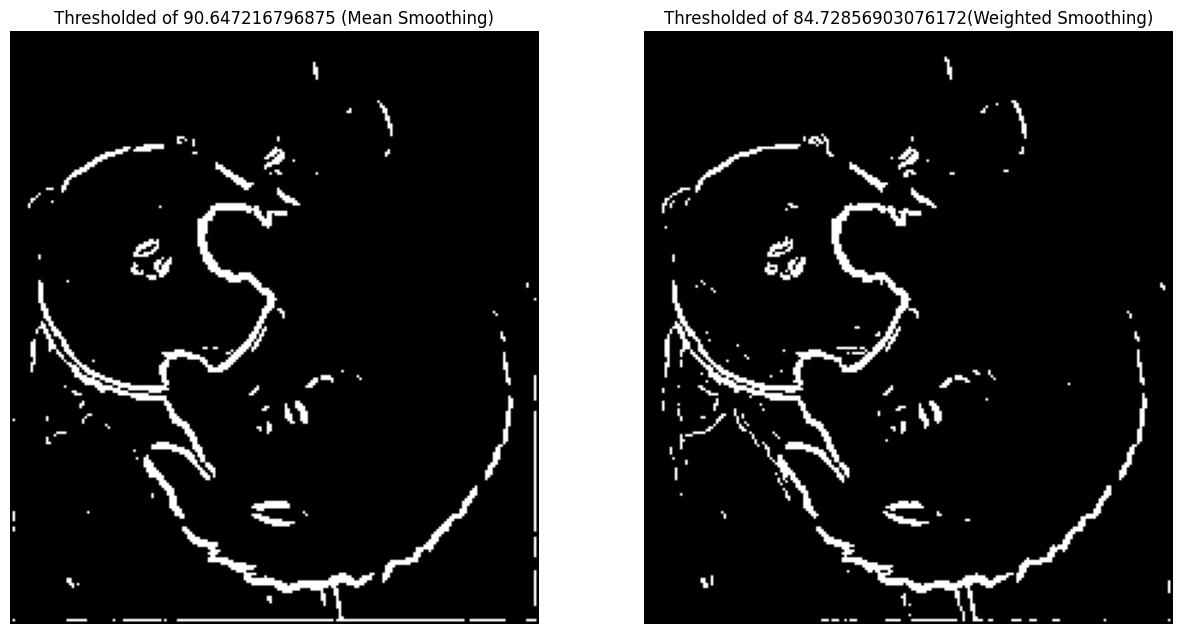

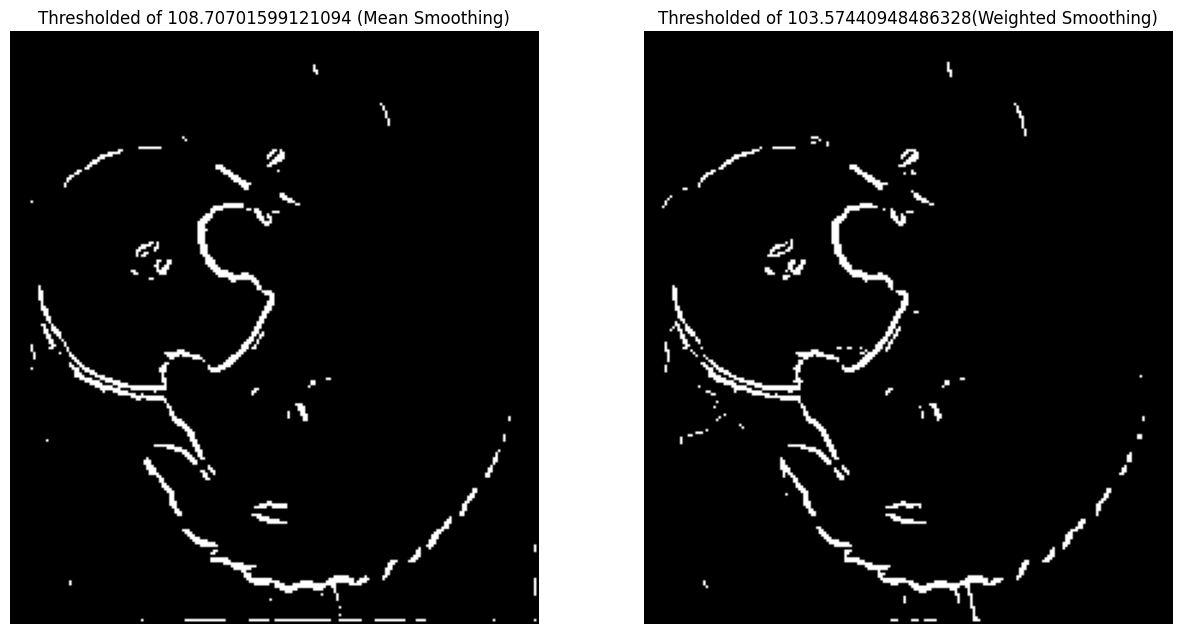

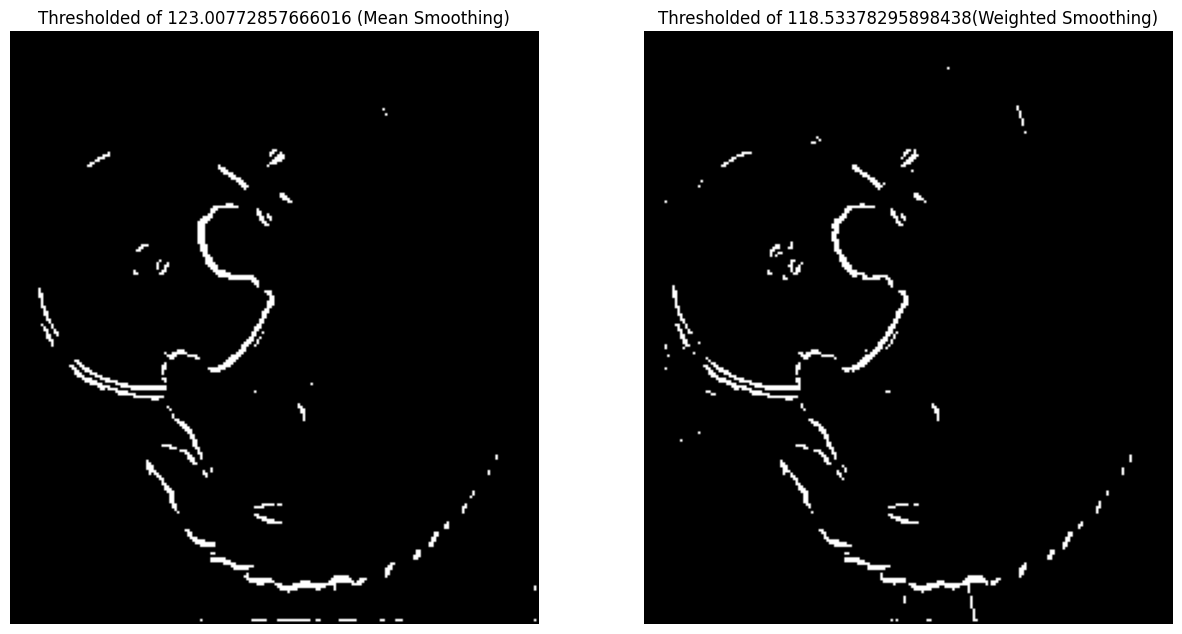

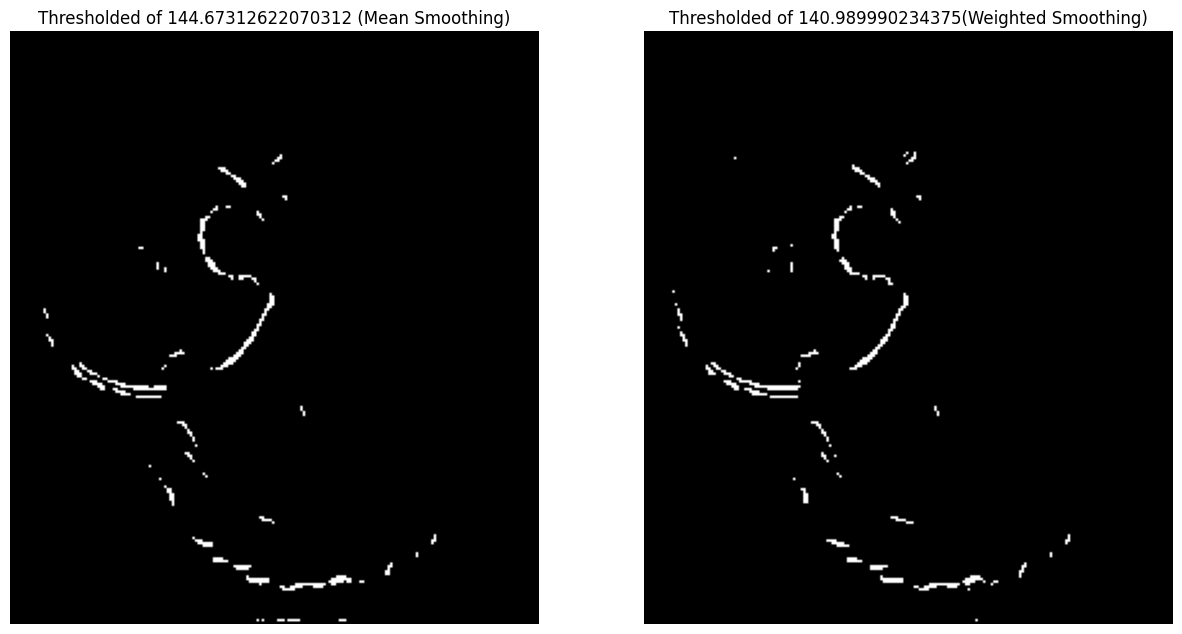

In [171]:
threshold=[85,87,90,92,95,97,98,99]
for i in threshold:
    apply_adaptive_threshold_manual, thresholdM = apply_adaptive_threshold(gradient_magnitude_manual,i)
    apply_adaptive_threshold_weighted, thresholdW = apply_adaptive_threshold(gradient_magnitude_weighted,i)

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(apply_adaptive_threshold_manual, cmap='gray')
    ax[0].set_title(f"Thresholded of {thresholdM} (Mean Smoothing)")
    ax[0].axis('off')
    ax[1].imshow(apply_adaptive_threshold_weighted, cmap='gray')
    ax[1].set_title(f"Thresholded of {thresholdW}(Weighted Smoothing)")
    ax[1].axis('off')
    plt.show()
